файлы: train_vw3.txt - приведённые к нормальной форме слова, записанные в формате vw <br/>
normalized_text.txt - удалены пустые строки <br/>
normalized_text2.txt - к каким возможно словам приклеены части речи (для работы с моделями word2vec)<br/>
nltk_pos.txt - тоже самое, но через nltk,  а не pymorphy

In [339]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
%matplotlib inline
# преобразование строчек словарей в словарь
import ast
import json
# преобразование адресов скринов в md5
import hashlib
# для текстов
import artm
import os
# для картинок
from __future__ import division, print_function
from scipy.misc import imresize
from keras.models import Model
from PIL import Image
from pymystem3 import Mystem
m = Mystem()

In [39]:
data = pd.read_table("df_export_all_new.tsv")

In [40]:
data.columns

Index(['itemId', 'publisherItemId', 'addTime', 'autobanned',
       'byHandModerationStatus', 'tolokaModerationStatus', 'images', 'isSuper',
       'modTime', 'narrativeStateJson', 'publishTime', 'slidesCount',
       'type_counts', 'text', 'title', 'screenshots',
       'publisherFavouritesCount', 'publisherMonetizationAvailable',
       'publisherPublications', 'publisherRegTime', 'publisherQualityNumeric'],
      dtype='object')

In [41]:
data.columns

Index(['itemId', 'publisherItemId', 'addTime', 'autobanned',
       'byHandModerationStatus', 'tolokaModerationStatus', 'images', 'isSuper',
       'modTime', 'narrativeStateJson', 'publishTime', 'slidesCount',
       'type_counts', 'text', 'title', 'screenshots',
       'publisherFavouritesCount', 'publisherMonetizationAvailable',
       'publisherPublications', 'publisherRegTime', 'publisherQualityNumeric'],
      dtype='object')

Всего записей

In [42]:
len(data)

13365

Количество авторов публикаций

In [43]:
len(data.publisherItemId.unique())

3697

Все забаненные нарративы становятся BAD_FOR_RECOMMENDER

In [44]:
data.loc[(data['autobanned']==True) | (data['tolokaModerationStatus']=='BAD_FOR_RECOMMENDER'), 'byHandModerationStatus'] = 'BAD_FOR_RECOMMENDER'

Вывод из категории Super нарративов, которые BAD_FOR_RECOMMENDER

In [45]:
data.loc[(data['isSuper']==True) & (data['byHandModerationStatus']=='BAD_FOR_RECOMMENDER'), 'isSuper'] = False

Проверяю, что остались только isSuper, BAD, UNKNOWN

In [46]:
data.loc[(data['isSuper']==False) & (data['byHandModerationStatus']=='UNKNOWN'), 'isSuper'] = False

In [47]:
data['res'] = pd.Series(np.zeros(len(data)))

In [48]:
data.loc[data.byHandModerationStatus=='OK', 'res'] = 3
data.loc[data.isSuper==True, 'res'] = 2
data.loc[data.byHandModerationStatus=='BAD_FOR_RECOMMENDER', 'res'] = 1

In [49]:
counted_ind = data[data.res!=0].index
not_counted_ind = data[data.res==0].index

In [50]:
data.loc[(data.tolokaModerationStatus=='OK') & (data.autobanned==False) & data.res==0, 'res'] = 3

Остался класс 0, т.е. неотносящиеся к одному из трёх классов значения

In [51]:
data.res.unique()

array([2., 1., 3.])

Посмотреть на эти данные

In [52]:
# t = data[data.res==0.0].head(1)
# for col in t.columns:
#     print(col, t[col].values[0])

Больше трети нарративов!

In [53]:
len(data[data.res==0.0])

0

С временем и количеством слайдов проблем нет

In [54]:
len(data[(data.addTime>data.publishTime) | (data.addTime>data.modTime)])

0

In [55]:
data.slidesCount.unique()

array([10, 12, 11,  6,  7,  9,  8,  5,  4,  3,  2,  1])

Перевод времени регистрации автора из datetime в timestamp

In [56]:
data.loc[:, 'publisherRegTime'] = (pd.DatetimeIndex(data.publisherRegTime).astype(np.int64) / 1000000).astype(np.int64)

Смотрю на длину текста сначала для плохих, а потом для неплохих нарративов
Смена разметки текста значительно изменило гистограммы (сверху - до, снизу - после)

Выделение фичей из type_counts

In [57]:
list(ast.literal_eval(data.type_counts[0]).keys())

['url', 'text', 'image', 'video', 'text-title']

In [58]:
big_dict = {}
d_keys = list(ast.literal_eval(data.type_counts[0]).keys())
for key in d_keys:
    big_dict[key] = []
for str_dict in data.type_counts:
    curr_dict = ast.literal_eval(str_dict)
    for key in d_keys:
        big_dict[key].append(curr_dict[key])
big_dict['text_num'] = big_dict['text']
big_dict['text_title'] = big_dict['text-title']
big_dict.pop('text', None)
_ = big_dict.pop('text-title', None)

In [59]:
text_type_features = pd.DataFrame(big_dict)

In [60]:
data = pd.concat([data, text_type_features], axis=1)

In [61]:
data.columns

Index(['itemId', 'publisherItemId', 'addTime', 'autobanned',
       'byHandModerationStatus', 'tolokaModerationStatus', 'images', 'isSuper',
       'modTime', 'narrativeStateJson', 'publishTime', 'slidesCount',
       'type_counts', 'text', 'title', 'screenshots',
       'publisherFavouritesCount', 'publisherMonetizationAvailable',
       'publisherPublications', 'publisherRegTime', 'publisherQualityNumeric',
       'res', 'image', 'text_num', 'text_title', 'url', 'video'],
      dtype='object')

In [62]:
data.loc[data.tolokaModerationStatus=='BAD_FOR_RECOMMENDER', 'tolokaModerationStatus'] = 0
data.loc[data.tolokaModerationStatus=='OK', 'tolokaModerationStatus'] = 1

In [63]:
data['addPublishTime'] = data.publishTime-data.addTime

In [64]:
train_df = data[data.res!=0]
train_df2 = data[data.res!=0]
test_df = data[data.res==0]

In [65]:
train_df = train_df.iloc[counted_ind]

In [66]:
data.loc[((data.tolokaModerationStatus=='BAD_FOR_RECOMMENDER') | (data.autobanned)) & (data.isSuper), 'byHandModerationStatus']

Series([], Name: byHandModerationStatus, dtype: object)

In [67]:
len(data.loc[((data.tolokaModerationStatus=='BAD_FOR_RECOMMENDER') | (data.autobanned)) & (data.byHandModerationStatus=='OK'), :])

0

Краткий обзор что сделано за неделю.
План на следующую неделю. В письме.

WordToVec. LDA embedding кластера. Близость к центроидам кластера. ALS
Суммировать слова взвесив tfidf или ParagraphVector; SentToVec
Делать tSNE картинки
Гистограммы по картинкам (не основной приоритет)
Анализ паблишеров (не приоритет), связь с quality

https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5

Много дополнительных слов удалил из текста, поэтому думаю стоит записать как отдельную фичу

In [68]:
l = []
with open("train_vw3.txt") as f:
    strings = f.readlines()
    l = [s[7:] for s in strings]
# l = [doc for doc in l if doc!=['\n']]

In [69]:
len([doc for doc in l if doc!=['\n']])

8045

In [70]:
train_df.loc[train_df.text.notnull(), 'norm_words_text'] = np.array(l)

In [71]:
empty_strings_len = len(train_df.loc[train_df.norm_words_text=='\n', 'norm_words_text'])

In [72]:
train_df.loc[train_df.norm_words_text=='\n', 'norm_words_text'] = np.array([np.nan]*empty_strings_len)

In [73]:
len(train_df.loc[train_df.norm_words_text.notnull(), 'norm_words_text'])

8014

In [74]:
import urllib.request

url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"

with urllib.request.urlopen(url) as response:
    swfile = response.read().decode("utf-8")

    stopwords = set(map(lambda x: x.strip(), swfile.split("\n")))

    # вообще можно всякий хлам отфильтровать и простой регуляркой, но мы добавим его в стоп-слова
    for punkt in ")(,;:?-_*[]}{\"'><!.*#`/\\|&^%$@~":
        stopwords.add(punkt)
        
# stopwords = set(['канал', 'добавлять', 'подписываться', 'читать', 'статья'])

In [75]:
import artm

from sklearn.feature_extraction.text import CountVectorizer
from numpy import array

cv = CountVectorizer(max_features=1000, stop_words=stopwords)
n_wd = array(cv.fit_transform(l).todense()).T
vocabulary = cv.get_feature_names()

bv = artm.BatchVectorizer(data_format='bow_n_wd',
                          n_wd=n_wd,
                          vocabulary=vocabulary)
# Learn simple LDA model (or you can use advanced artm.ARTM)
model = artm.LDA(num_topics=20, dictionary=bv.dictionary, cache_theta=True)
model.fit_offline(bv, num_collection_passes=25)
# model.load('artmmodel')
model.save('artmmodel_20themes')
# Print results
model.get_top_tokens()

KeyboardInterrupt: 

In [76]:
# topic_matrix = model.transform(bv).transpose()
topic_matrix = pd.read_table('topic_probs.csv')

In [40]:
from sklearn.manifold import TSNE
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/pavelgulaev/anaconda2/envs/python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [41]:
# X_tsne = TSNE(learning_rate=500).fit_transform(topic_matrix)

In [42]:
# figure(figsize=(10, 10))
# scatter(X_tsne[:, 0], X_tsne[:, 1], c=topic_matrix.idxmax(axis=1))

In [77]:
topic_matrix.index = train_df.loc[train_df.text.notnull()].index

In [78]:
train_df = pd.concat([train_df, topic_matrix], axis=1)

In [79]:
train_df.loc[train_df.text.isnull(), topic_matrix.columns] = 0.0

In [80]:
topic_matrix.columns

Index(['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11',
       'topic_12', 'topic_13', 'topic_14'],
      dtype='object')

In [81]:
topic_matrix.columns = [i for i in range(15)]

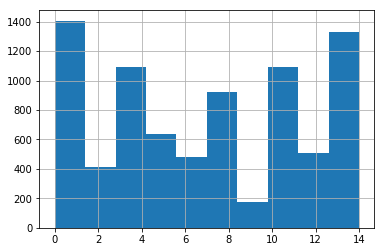

In [82]:
topic_matrix.idxmax(axis=1).hist()

In [83]:
train_df = pd.concat([train_df, topic_matrix.idxmax(axis=1)], axis=1)

In [84]:
len(train_df)

8385

In [85]:
train_df = train_df.rename(index=str, columns={0:'top_theme'})

In [86]:
train_df.loc[train_df.top_theme.isnull(), 'top_theme'] = 15

In [87]:
train_df.top_theme.unique()

array([ 1., 10., 14., 12.,  5.,  6., 13., 11.,  0.,  3.,  2.,  4.,  8.,
       15.,  7.,  9.])

Преобразовать для теста гемморно: <br/>
1) нужно сделать текстовый файл с нормализованнным и обрезанным текстом <br/>
2) нужно сделать второй BatchVectorizer <br/>
3) transform bv по model

Надо что сделать с нарративами autobanned или toloka?

In [88]:
probs = np.load('probs.npy')

In [89]:
probs_cols = pd.DataFrame(probs, columns=['prob_bad', 'prob_super', 'prob_ok'], index=train_df2.index)

In [90]:
len(train_df)

8385

In [91]:
len(counted_ind)

8385

In [92]:
len(train_df2)

13365

In [93]:
# train_df3 = train_df.loc[:,:]

In [94]:
train_df.index = train_df.index.astype(int)

In [95]:
probs_cols2 = probs_cols.iloc[counted_ind]
train_df = pd.concat([train_df, probs_cols2], axis=1)

In [96]:
train_df.loc[((train_df.autobanned==True) | (train_df.tolokaModerationStatus=='BAD')), 'res'].value_counts()

3.0    24
Name: res, dtype: int64

In [97]:
print(len(train_df.loc[train_df.text.notnull(), 'res']))
train_df.loc[train_df.text.notnull(), 'res'].value_counts()

8045


3.0    5598
2.0    1731
1.0     716
Name: res, dtype: int64

Очень странная особенность! Почти сто нарративов хороши абсолютно без текста

In [98]:
train_df.loc[train_df.text.isnull(), 'res'].value_counts()

1.0    238
2.0     61
3.0     41
Name: res, dtype: int64

In [99]:
import logging
import sys
import os
from word2vec import Word2Vec, Sent2Vec, LineSentence

/Users/pavelgulaev/anaconda2/envs/python3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Преобразование моих слов к форме слово_ЧАСТЬРЕЧИ, у которых получится. Остальные просто остаются словами. <br/>
Никакой частиречной разметки нет, просто беру первый выданный тэг.

In [100]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
with open('normalized_texts.txt') as t:
    strings = t.readlines()
    with open('normalized_texts2.txt', "w") as f1:
        for string in strings:
            string = string.replace('\n','')
            for word in string.split(' '):
#                 print(word)
                if (morph.parse(word)[0].tag.POS==None):
                    f1.write(word+' ')
                else:
                    f1.write(word+'_'+morph.parse(word)[0].tag.POS+' ')
            f1.write('\n')
#     [[word+'_'+morph.parse(word)[0].tag.POS for word in string.split(' ')] for string in strings]

KeyboardInterrupt: 

In [208]:
to_ut = {'ADJF':'ADJ','ADJS':'ADJ','COMP':'ADV','ADVB':'ADV','PRED':'ADV','CONJ':'SCONJ','INTJ':'INTJ','NUMR':'NUM','PRCL':'PART','PREP':'ADP','NOUN':'NOUN','NPRO':'PRON','VERB':'VERB','INFN':'VERB','PRTF':'VERB','PRTS':'VERB','GRND':'VERB'}

In [211]:
with open('normalized_texts2.txt') as t:
    strings = t.readlines()
    with open('normalized_texts3.txt', "w") as f1:
        for string in strings:
            for tag, new_tag in to_ut.items():
                string.replace(tag, new_tag)
            f1.write(string)

In [136]:
logging.basicConfig(format='%(asctime)s : %(threadName)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.info("running %s" % " ".join(sys.argv))

sent_file = 'nltk_pos'
model = Sent2Vec(LineSentence(sent_file+'.txt'), model_file='web_upos_cbow.model', sg=0, hs=0, iteration=3, workers=2)
model.save_sent2vec_format(sent_file + '.vec')

program = os.path.basename(sys.argv[0])
logging.info("finished running %s" % program)


2018-03-22 09:26:21,447 : MainThread : INFO : running /Users/pavelgulaev/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py -f /Users/pavelgulaev/Library/Jupyter/runtime/kernel-08e57cfe-e9d5-4cc7-811c-d6c58916d03a.json
2018-03-22 09:26:21,450 : MainThread : INFO : loading Word2Vec object from web_upos_cbow.model
2018-03-22 09:26:22,580 : MainThread : INFO : loading syn0 from web_upos_cbow.model.syn0.npy with mmap=None
2018-03-22 09:26:23,587 : MainThread : INFO : setting ignored attribute syn0norm to None
2018-03-22 09:26:23,599 : MainThread : INFO : resetting vectors for sentences
2018-03-22 09:26:24,017 : MainThread : INFO : training model with 2 workers on 8014 sentences and 300 features, using 'skipgram'=0 'hierarchical softmax'=0 'subsample'=0 and 'negative sampling'=0
2018-03-22 09:26:25,812 : Thread-7 : INFO : PROGRESS: at 0.42% sents, alpha 0.02500, 4028 words/s
2018-03-22 09:26:27,265 : Thread-6 : INFO : PROGRESS: at 1.25% sents, alpha 0.02500, 7114 words

In [101]:
# normalized_texts_ut
all_vecs = []
with open('nltk_pos.vec', 'r') as vecs_file:
    vecs = vecs_file.readlines()
    for vec in vecs:
        nums = vec.split(' ')
        nums = nums[1:]
        all_vecs.append(nums)
all_vecs = np.array(all_vecs[1:])

In [102]:
all_vecs.shape

(8014, 300)

In [139]:
names = ['sent_'+str(i) for i in range(300)]

In [107]:
new_train_df = train_df[train_df.norm_words_text.notnull()]

In [141]:
sent_features = pd.DataFrame(all_vecs, columns=names, index=new_train_df.index)

In [142]:
sent_features.head(1)

,sent_0,sent_1,sent_2,sent_3,sent_4,sent_5,sent_6,sent_7,sent_8,sent_9,...,sent_290,sent_291,sent_292,sent_293,sent_294,sent_295,sent_296,sent_297,sent_298,sent_299
0,-0.000277,0.000734,-0.001666,-0.000659,-0.001177,-0.001359,-0.001046,-0.000515,-0.000344,0.000129,...,0.000063,0.000903,0.000230,-0.000114,-0.000524,-0.001439,-0.000407,-0.001401,0.001609,-0.001061\n


In [143]:
len(sent_features)

8014

In [144]:
new_train_df = pd.concat([new_train_df, sent_features], axis=1)

Центроиды векторов класса LDA.

In [145]:
new_train_df.res.value_counts()

3.0    5517
2.0    1729
1.0     768
Name: res, dtype: int64

In [109]:
y_new = new_train_df.res
X_new = new_train_df.drop('res', axis = 1)
# X_test = test_df.drop('res', axis = 1)

In [110]:
X_new = X_new.drop(['itemId', 'publisherItemId', 'addTime', 'autobanned',
       'byHandModerationStatus', 'tolokaModerationStatus', 'images', 'isSuper',
       'modTime', 'narrativeStateJson', 'publishTime', 'type_counts', 
        'publisherRegTime', 'text', 'norm_words_text', 'title',
         'screenshots'], axis=1)

In [111]:
X_train, X_validation, y_train, y_validation = train_test_split(X_new, y_new, train_size=0.8, random_state=13)

/Users/pavelgulaev/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [149]:
stem_to_ut = {'A':'ADJ', 'PRAEDIC':'ADV','PARENTH':'ADV', 'INIT':'S', 'ADV':'ADV', 'ADVPRO':'ADV', 'ANUM':'ADJ', 'APRO':'DET', 'COM':'ADJ', 'CONJ':'SCONJ', 'INTJ':'INTJ', 'NONLEX':'X', 'NUM':'NUM', 'PART':'PART', 'PR':'ADP', 'S':'NOUN', 'SPRO':'PRON', 'UNKN':'X', 'V':'VERB'}

In [35]:
import nltk

with open('normalized_texts.txt') as t:
    strings = t.readlines()
    with open('nltk_pos.txt', "w") as f1:
        for string in strings:
            string = tf_idftokenizer(string)
            tags = nltk.pos_tag(string, lang='rus')
            for word, tag in zip(text,tags):
                try:
                    tag = stem_to_ut[tag[1].split('=')[0].split('-')[0].replace('-','')]
                except KeyError:
                    print(tag)
                f1.write(word+'_'+tag+' ')
            f1.write('\n')
#     [[word+'_'+morph.parse(word)[0].tag.POS for word in string.split(' ')] for string in strings]

KeyboardInterrupt: 

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [320]:
tfidfvect = TfidfVectorizer('nltk_pos.txt', strip_accents = None, token_pattern="(?u)\\b\\w+_\\w+\\b", lowercase=False)
# tfidfvect.fit_transform(train_df.norm_words_text)

In [321]:
anal = tfidfvect.build_analyzer()
anal(l[0])

['аэросани_NOUN',
 'подвесной_VERB',
 'топливный_ADJ',
 'бак_NOUN',
 'окисляться_VERB',
 'труба_NOUN',
 'выглядеть_VERB',
 'плавник_NOUN',
 'приносить_VERB',
 'море_NOUN',
 'бревно_ADV',
 'упасть_VERB',
 'тундра_NOUN',
 'деталь_NOUN',
 'ракета_NOUN',
 'кстати_ADV',
 'деталь_NOUN',
 'ракета_NOUN',
 'встречать_VERB',
 'ракета_NOUN',
 'запускать_VERB',
 'космодром_NOUN',
 'плесецк_NOUN',
 'тиманский_ADJ',
 'берег_NOUN',
 'баренцев_NOUN',
 'море_NOUN',
 'остров_NOUN',
 'колгуев_NOUN',
 'падать_VERB',
 'недогорать_VERB',
 'ступень_NOUN',
 'нарты_NOUN',
 'море_NOUN',
 'среди_ADP',
 'плавник_NOUN',
 'бросать_VERB',
 'лодочка_NOUN',
 'запчасть_NOUN',
 'самолет_NOUN',
 'кресло_VERB',
 'необитаемый_ADJ',
 'побережье_NOUN',
 'баренцев_NOUN',
 'море_NOUN',
 'весы_NOUN']

In [322]:
tfidfmatr = tfidfvect.fit_transform(new_train_df.pos_norm_words_text)

In [323]:
w2vmodel = Word2Vec.load('web_upos_cbow.model')

In [324]:
list_names[:10]

['a_x',
 'aaaaaelmzskjwlxcutjbjg_x',
 'aaaaafeuugxjdekvufdrg_x',
 'aaacbdbee_x',
 'aabccacff_x',
 'aacdddee_x',
 'aacdecfec_x',
 'aacfbe_x',
 'aacfcde_x',
 'aadbfccc_x']

In [325]:
list_names = tfidfvect.get_feature_names()
d = {}
i = 0
i=0
for name in list_names:
    d[name] = i
    i+=1

In [326]:
result = np.zeros((300,))

In [327]:
l = []
with open("nltk_pos.txt") as f:
    strings = f.readlines()
    l = [s for s in strings]
# l = [doc for doc in l if doc!=['\n']]

In [328]:
len([doc for doc in l if doc!=['\n']])

8014

In [329]:
train_df.loc[train_df.norm_words_text.notnull(), 'pos_norm_words_text'] = np.array(l)

In [330]:
new_train_df = train_df.loc[train_df.norm_words_text.notnull()]

In [331]:
np.unique(curr_tfidf.tolist())

array([0.        , 0.07350832, 0.08578138, 0.08896407, 0.09028823,
       0.09402332, 0.0949703 , 0.09631585, 0.10019933, 0.10154909,
       0.10202249, 0.11202921, 0.11573215, 0.11791523, 0.11850507,
       0.13097365, 0.13655283, 0.13826731, 0.14468331, 0.14745623,
       0.15073589, 0.15474988, 0.15992481, 0.16721847, 0.19708812,
       0.26709561, 0.28032515, 0.3456762 , 0.36165434])

In [344]:
curr_tfidf = tfidfmatr[0].T.todense()
it = 0
for i in curr_tfidf:
    if (i>0):
        print(it, w2vmodel[list_names[it]], i, curr_tfidf[d[list_names[it]]])
    it+=1

9261 [-0.0862374  -0.05538213  0.00790989 -0.02303715  0.06858708 -0.02333868
 -0.00133777  0.05880633 -0.01087078  0.03680762  0.01470745 -0.03614377
 -0.00543735 -0.06077111  0.09814735 -0.03122557 -0.09743093  0.02902042
 -0.06901989 -0.01763851 -0.1034911   0.04342104  0.03675746  0.0175088
  0.04102489 -0.01695042 -0.03625201 -0.0317533  -0.02499789 -0.01871906
 -0.0137238  -0.04526219  0.12682898 -0.09505355 -0.06209813 -0.02353349
 -0.02483843 -0.00123386  0.02276472 -0.06593549 -0.08796863 -0.03156487
 -0.00314414 -0.0336886  -0.03275806 -0.00674722 -0.02713146 -0.01735789
 -0.02943204  0.01624132 -0.05259793 -0.05075845  0.04006441  0.02167617
  0.04337622  0.03566468  0.04377756  0.02358954  0.02767344 -0.02154912
  0.08393212  0.05442163  0.00377612 -0.03246286 -0.00310978  0.18422107
 -0.05507045 -0.05215815  0.03521994  0.03835318  0.01750938  0.12010605
  0.01213215  0.0322244   0.01578703  0.07218217  0.03086394 -0.01873878
 -0.02970828  0.06723698  0.02502822 -0.0211509

KeyError: 'баренцев_NOUN'

In [375]:
it = 9261
w2vmodel[list_names[it]]

array([-0.0862374 , -0.05538213,  0.00790989, -0.02303715,  0.06858708,
       -0.02333868, -0.00133777,  0.05880633, -0.01087078,  0.03680762,
        0.01470745, -0.03614377, -0.00543735, -0.06077111,  0.09814735,
       -0.03122557, -0.09743093,  0.02902042, -0.06901989, -0.01763851,
       -0.1034911 ,  0.04342104,  0.03675746,  0.0175088 ,  0.04102489,
       -0.01695042, -0.03625201, -0.0317533 , -0.02499789, -0.01871906,
       -0.0137238 , -0.04526219,  0.12682898, -0.09505355, -0.06209813,
       -0.02353349, -0.02483843, -0.00123386,  0.02276472, -0.06593549,
       -0.08796863, -0.03156487, -0.00314414, -0.0336886 , -0.03275806,
       -0.00674722, -0.02713146, -0.01735789, -0.02943204,  0.01624132,
       -0.05259793, -0.05075845,  0.04006441,  0.02167617,  0.04337622,
        0.03566468,  0.04377756,  0.02358954,  0.02767344, -0.02154912,
        0.08393212,  0.05442163,  0.00377612, -0.03246286, -0.00310978,
        0.18422107, -0.05507045, -0.05215815,  0.03521994,  0.03

In [377]:
it = 0
summed_vecs = []
for text in new_train_df.pos_norm_words_text:
    curr_tfidf = tfidfmatr[it].T.todense()
    result = np.zeros((300,))
    text = text.strip()
    for word in text.split(' '):
#         print(word)
        try:
            currw2v = w2vmodel[word]
#             print(currw2v)
        except KeyError:
            currw2v = np.zeros((300,))
        try:
            tfidf_val = curr_tfidf[d[word]].tolist()[0][0]
        except KeyError:
            tfidf_val = 0
        result+=(currw2v*tfidf_val)
    
#     print(currw2v*curr_tfidf[d[name]].tolist()[0][0])
    summed_vecs.append(result)
    it+=1
    print(it)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [378]:
len(new_train_df)

8014

In [381]:
tfidf_features = pd.DataFrame(np.array(summed_vecs), columns=['w2v'+str(j) for j in range(300)], index=new_train_df.index)

In [383]:
new_train_df = pd.concat([new_train_df, tfidf_features], axis=1)

In [398]:
new_train_df.to_csv('data_with_w2v.csv', sep='\t', index=False)

In [133]:
len(np.ravel(Test.sum(axis=0).argsort(axis=1))[::-1])

50629

In [123]:
N=10
idx = np.ravel(Test.sum(axis=0).argsort(axis=1))[::-1][:N]
top_10_words = np.array(tfidfvect.get_feature_names())[idx].tolist()

In [124]:
top_10_words

['фото',
 'спичка',
 'интересный',
 'получать',
 'фильм',
 'помогать',
 'девушка',
 'масло',
 'кот',
 'рубль']

## Классификаторы

In [386]:
new_train_df.top_theme = train_df.top_theme.astype(int)

In [387]:
y = new_train_df.res
X = new_train_df.drop('res', axis = 1)
X_test = test_df.drop('res', axis = 1)

In [388]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1)

/Users/pavelgulaev/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [389]:
X.columns

Index(['itemId', 'publisherItemId', 'addTime', 'autobanned',
       'byHandModerationStatus', 'tolokaModerationStatus', 'images', 'isSuper',
       'modTime', 'narrativeStateJson',
       ...
       'w2v290', 'w2v291', 'w2v292', 'w2v293', 'w2v294', 'w2v295', 'w2v296',
       'w2v297', 'w2v298', 'w2v299'],
      dtype='object', length=348)

In [390]:
all_features = [
    'top_theme', 
    'addPublishTime',
                  'slidesCount', 
                'publisherFavouritesCount', 'publisherMonetizationAvailable',
               'publisherPublications', 'publisherQualityNumeric',
               'image', 'text_num', 'text_title', 'url', 'video',
                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11',
       'topic_12', 'topic_13', 'topic_14', 'prob_bad', 'prob_super', 'prob_ok']+['w2v'+str(j) for j in range(300)]

In [392]:
len(X_validation)

1603

In [393]:
cat_features = [0]

In [394]:
from catboost import CatBoostClassifier

In [395]:
unique, counts = np.unique(y_train, return_counts=True)
d = dict(zip(unique, counts))
d.update((x, y/len(y_train)) for x, y in d.items())
d

{1.0: 0.08844174075807207, 2.0: 0.2166588675713617, 3.0: 0.6948993916705662}

In [396]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{1.0: 706, 2.0: 1729, 3.0: 5579}

In [397]:
cbc = CatBoostClassifier(iterations=2500, loss_function='MultiClass', 
                           learning_rate=0.03, l2_leaf_reg=3, 
                           random_strength=0.7, bagging_temperature=0.9,
                           random_seed=0,
                           custom_loss=['AUC', 'Accuracy'],
                           use_best_model=True,
                           od_type='Iter',
#                            save_snapshot=True,
#                            snapshot_file='snapshot.bkp',
                           od_wait=50)
cbc.fit(X_train[all_features], y_train, 
#           cat_features=cat_features,
         eval_set=(X_validation[all_features], y_validation),
         plot=True)

/Users/pavelgulaev/anaconda2/envs/python3/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:166: DeprecationWarning: Widget._keys_default is deprecated in traitlets 4.1: use @default decorator instead.
  def _keys_default(self):


0:	learn: -1.3436702	test: -1.3444709	best: -1.3444709 (0)	total: 686ms	remaining: 28m 34s
1:	learn: -1.3042840	test: -1.3059879	best: -1.3059879 (1)	total: 1.3s	remaining: 27m
2:	learn: -1.2686217	test: -1.2711054	best: -1.2711054 (2)	total: 1.86s	remaining: 25m 52s
3:	learn: -1.2348478	test: -1.2380263	best: -1.2380263 (3)	total: 2.49s	remaining: 25m 55s
4:	learn: -1.2017693	test: -1.2059438	best: -1.2059438 (4)	total: 3.1s	remaining: 25m 48s
5:	learn: -1.1730695	test: -1.1778346	best: -1.1778346 (5)	total: 3.69s	remaining: 25m 34s
6:	learn: -1.1460692	test: -1.1514562	best: -1.1514562 (6)	total: 4.27s	remaining: 25m 20s
7:	learn: -1.1193304	test: -1.1257634	best: -1.1257634 (7)	total: 4.81s	remaining: 24m 59s
8:	learn: -1.0957566	test: -1.1026000	best: -1.1026000 (8)	total: 5.38s	remaining: 24m 49s
9:	learn: -1.0721973	test: -1.0798754	best: -1.0798754 (9)	total: 5.95s	remaining: 24m 41s
10:	learn: -1.0514953	test: -1.0602938	best: -1.0602938 (10)	total: 6.55s	remaining: 24m 43s
11:

KeyboardInterrupt: 

In [72]:
cbc.score(X_validation[all_features], y_validation)

0.8121645796064401

In [73]:
print(classification_report(y_validation, cbc.predict(X_validation[all_features])))

             precision    recall  f1-score   support

        1.0       0.90      0.59      0.71       205
        2.0       0.71      0.62      0.66       356
        3.0       0.83      0.92      0.87      1116

avg / total       0.81      0.81      0.81      1677



In [65]:
cbc.score(X_validation[all_features], y_validation)

0.7817531305903399

In [66]:
print(classification_report(y_validation, cbc.predict(X_validation[all_features])))

             precision    recall  f1-score   support

        1.0       0.86      0.52      0.65       205
        2.0       0.69      0.50      0.58       356
        3.0       0.79      0.92      0.85      1116

avg / total       0.78      0.78      0.77      1677



In [297]:
cbc.score(X_validation[all_features], y_validation)

0.802623732856291

In [298]:
print(classification_report(y_validation, cbc.predict(X_validation[all_features])))

             precision    recall  f1-score   support

        1.0       0.87      0.55      0.67       205
        2.0       0.70      0.60      0.65       356
        3.0       0.82      0.91      0.86      1116

avg / total       0.80      0.80      0.80      1677



In [65]:
cbc.score(X_validation[all_features], y_validation)

0.800834824090638

In [68]:
print(classification_report(y_validation, cbc.predict(X_validation[all_features])))

             precision    recall  f1-score   support

        1.0       0.88      0.57      0.69       214
        2.0       0.69      0.61      0.65       356
        3.0       0.82      0.91      0.86      1107

avg / total       0.80      0.80      0.79      1677



topics+besttopic

In [94]:
cbc.score(X_validation[all_features], y_validation)

0.7859272510435301

sent2vec + nltk

In [60]:
cbc.score(X_validation, y_validation)

0.7654398003742982

sent2vec + pymorphy

In [374]:
cbc.score(X_validation, y_validation)

0.7666874610106051

Для 15 тем

In [137]:
cbc.score(X_validation[all_features], y_validation)

0.7966607036374478

Для 20 тем

In [164]:
cbc.score(X_validation[all_features], y_validation)

0.7996422182468694

Без использования LDA

In [36]:
cbc.score(X_validation[all_features], y_validation)

0.7847346451997614

In [237]:
y_cbc_pred = model.predict(X_validation[all_features])
print(classification_report(y_validation, y_cbc_pred))
unique, counts = np.unique(y_cbc_pred, return_counts=True)
dict(zip(unique, counts))

             precision    recall  f1-score   support

        1.0       0.91      0.64      0.75       214
        2.0       0.88      0.72      0.79       356
        3.0       0.86      0.97      0.91      1107

avg / total       0.87      0.87      0.87      1677



{1.0: 149, 2.0: 290, 3.0: 1238}

In [191]:
from catboost import Pool
pool1 = Pool(data=X[all_features], label=y, cat_features=cat_features)

In [192]:
importances = np.array(model.feature_importances_)
f_names = np.array(pool1.get_feature_names())
for i in range(len(importances)):
    print(f_names[i], importances[i])

autobanned 0.23763970363103715
tolokaModerationStatus 1.0775239665613656
addTime 22.800030899976374
modTime 15.5879714756911
slidesCount 12.491067834887879
publisherFavouritesCount 8.196984575250992
publisherMonetizationAvailable 1.909938424303454
publisherPublications 8.039280796568265
publisherRegTime 7.669611155513511
publisherQualityNumeric 1.109546957109931
image 5.357056648269509
text_num 11.634753497266011
text_title 0.001313783558734919
url 1.9226272466437724
video 1.964653034768075


In [112]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
rfc.fit(X_train[all_features], y_train)
y_rfc_pred = rfc.predict(X_validation[all_features])
accuracy_score(y_rfc_pred, y_validation)

0.7891453524641298

In [116]:
y_test_rfc = rfc.predict(X_test[all_features])
y_test = [3]*len(X_test)
accuracy_score(y_test_rfc, y_test)

0.8827309236947791

In [117]:
unique, counts = np.unique(y_test_rfc, return_counts=True)
dict(zip(unique, counts))

{1.0: 235, 2.0: 349, 3.0: 4396}

In [119]:
# print(classification_report(y, y_rfc_pred))
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{1.0: 1022, 2.0: 1792, 3.0: 5571}

In [125]:
data.iloc[1753,:]

itemId                                             4ddb79006b495a5fb003127906a3a112
publisherItemId                                    382e178225ee7494a9b1f1db77f678cd
addTime                                                               1518012190863
autobanned                                                                    False
byHandModerationStatus                                                           OK
tolokaModerationStatus                                                            1
images                            [{u'porno': 0, u'is_deleted': False, u'multicl...
isSuper                                                                       False
modTime                                                               1518018622074
narrativeStateJson                {"slides":["r03em","9wulc","44n5g","zd746","1m...
publishTime                                                           1518012190863
slidesCount                                                                 

In [207]:
from sklearn.ensemble import BaggingClassifier

In [211]:
rfc_for_bagging = RandomForestClassifier(n_estimators=100, random_state=0)

In [213]:
bc = BaggingClassifier(base_estimator=rfc_for_bagging, n_estimators=100, random_state=0, max_features=0.5)
bc.fit(X_train[all_features], y_train)
y_bc_pred = bc.predict(X_validation[all_features])
accuracy_score(y_validation, y_bc_pred)

0.8438617401668653

In [230]:
print(classification_report(y_validation, y_bc_pred))

             precision    recall  f1-score   support

        1.0       0.90      0.55      0.68        94
        2.0       0.89      0.58      0.70       180
        3.0       0.83      0.98      0.90       565

avg / total       0.85      0.84      0.83       839



In [228]:
unique, counts = np.unique(y_bc_pred, return_counts=True)
dict(zip(unique, counts))

{1.0: 58, 2.0: 118, 3.0: 663}

Пример работы со скриншотами

In [167]:
m = hashlib.md5()
m.update(u"https://storage.mds.yandex.net/get-mturk/758055/b67a1117-24fe-447f-84ba-4d3d5821191a.png".encode('utf-8'))
print(m.hexdigest())
m = hashlib.md5()
m.update(u"https://storage.mds.yandex.net/get-mturk/466326/0b057aca-b7fe-47a6-aee0-f476dbf34d23.png".encode('utf-8'))
print(m.hexdigest())

83b3e91932675563b44cf820a77f2c97
6f3e1aa94c9f7c670b2441b2bfe7014b


In [24]:
m = hashlib.md5()
m.update(u"https://storage.mds.yandex.net/get-mturk/758055/b67a1117-24fe-447f-84ba-4d3d5821191a.png".encode('utf-8'))
print(m.hexdigest())
m = hashlib.md5()
m.update(u"https://storage.mds.yandex.net/get-mturk/466326/0b057aca-b7fe-47a6-aee0-f476dbf34d23.png".encode('utf-8'))
print(m.hexdigest())

83b3e91932675563b44cf820a77f2c97
6f3e1aa94c9f7c670b2441b2bfe7014b
